In [1]:
import numpy as np
from scipy import *
from pylab import *
import os
from scipy import interpolate,stats
from scipy.integrate import quad
import scipy.optimize as op
import sys, os
import hmf
from peak_bias_func import *

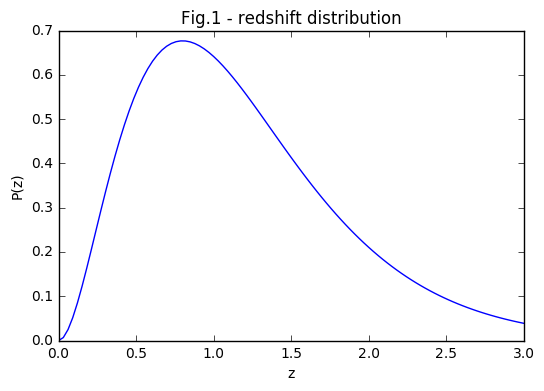

In [2]:
z_arr = linspace(0,3,100)
plot(z_arr,Pz(z_arr))
xlabel('z');ylabel('P(z)')
xlim(0,3)
title('Fig.1 - redshift distribution')
show()

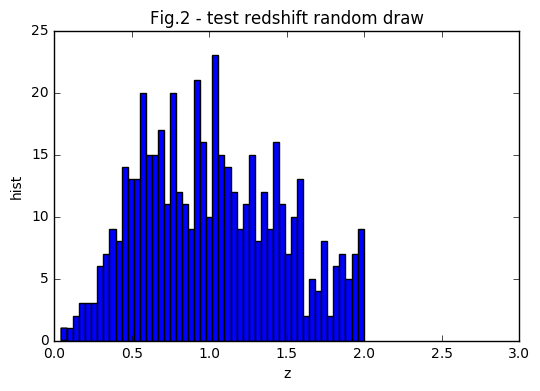

In [3]:
sample = redshift_gen(500)
hist(sample,bins=50);xlabel('z');ylabel('hist');
xlim(0,3)
title('Fig.2 - test redshift random draw')
show()

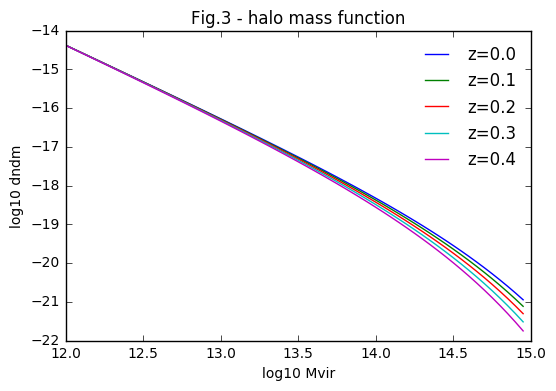

In [4]:
###### halo mass function ######
dndm_arr = array([hmf.MassFunction(z=iz, Mmin=Mmin, Mmax=Mmax, dlog10m=dlog10m).dndm for iz in z_choices])
# save('dndm_arr.npy',dndm_arr)
z_arr, M_arr = z_choices, arange(Mmin,Mmax,dlog10m)

for iii in range(5):
    plot(M_arr, log10(dndm_arr[25*iii]),label='z=%s'%(z_choices[25*iii]))
xlabel('log10 Mvir')
ylabel('log10 dndm')
title('Fig.3 - halo mass function')
legend(frameon=0,loc=0)
show()


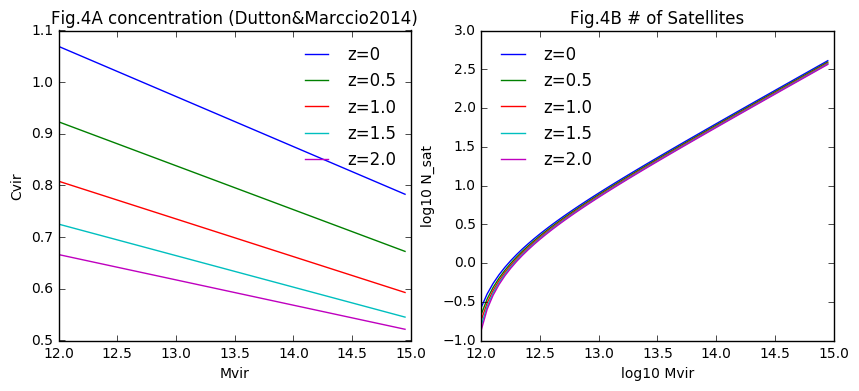

In [5]:
figure(figsize=(10,4))
subplot(121)
[plot(M_arr, log10(Cvir(M_arr, iz)), label='z=%s'%(iz)) for iz in (0,0.5,1.0,1.5,2.0)]
xlabel('Mvir')
ylabel('Cvir')
legend(frameon=0,loc=0)
title('Fig.4A concentration (Dutton&Marccio2014)')
subplot(122)
[plot(M_arr, log10(N_lens_fcn(M_arr, iz)), label='z=%s'%(iz)) for iz in (0,0.5,1.0,1.5,2.0)]
xlabel('log10 Mvir')
ylabel('log10 N_sat')
title('Fig.4B # of Satellites')
legend(frameon=0,loc=0)
show()

In [19]:
########## test run with one massive lens ############
M_lens = 14.5
z_lens = 0.4
N_lens = int(N_lens_fcn(M_lens, z_lens) + 0.5)

seed(0)
Mvir = 10**M_lens
cNFW = Cvir(M_lens, z_lens)
Rvir = Rvir_fcn(Mvir,z_lens)
ngal_like_fcn = lambda cNFW: array([Gx_fcn(ix, cNFW) for ix in linspace(0.01, cNFW, 1001)]).T
ngal_like = ngal_like_fcn(cNFW)/sum(ngal_like_fcn(cNFW))
rlenses = Rvir/Mpc/DC(z_lens) * np.random.choice(linspace(0.01, 1.0, 1001), size=N_lens, p=ngal_like)#radians
ang_lenses = rand(N_lens)*2*pi
xlens = degrees(rlenses)*60.0 * sin(ang_lenses) ## in arcmin
ylens = degrees(rlenses)*60.0 * cos(ang_lenses) ## in arcmin
theta_vir = degrees(Rvir/Mpc/DC(z_lens))*60.0


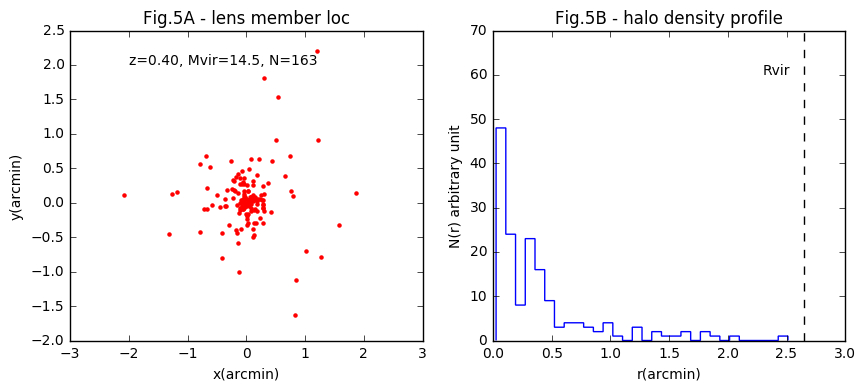

In [20]:
figure(figsize=(10,4))
subplot(121)
scatter(xlens, ylens, c='r', s=5, edgecolor='r')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.5A - lens member loc')
text(-2,2,'z=%.2f, Mvir=%.1f, N=%i'%(z_lens, M_lens, N_lens))
subplot(122)
hist(degrees(rlenses)*60.0, bins=30,histtype='step')
plot([theta_vir,theta_vir],[0,70],'k--')
xlabel('r(arcmin)')
ylabel('N(r) arbitrary unit')
text(2.3,60,'Rvir')
title('Fig.5B - halo density profile')
show()

In [21]:
side = 10.0
area = side**2 ## arcmin^2
N_gal = Ngal_gen(ngal_mean * area)
z_source_arr = redshift_gen(N_gal)
x_source_arr = rand(N_gal) * side
y_source_arr = rand(N_gal) * side


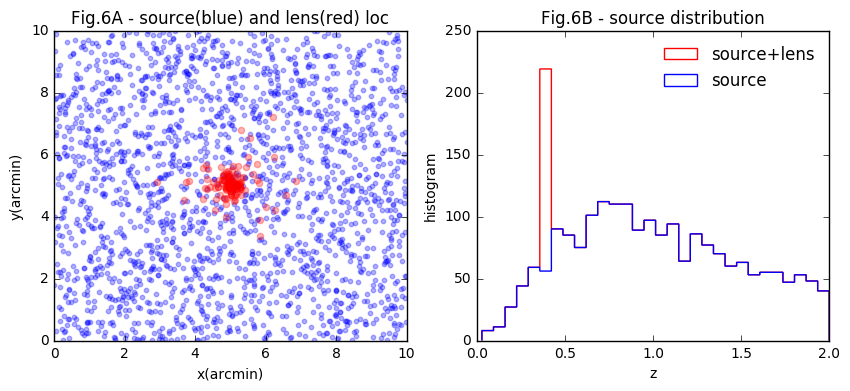

In [22]:
figure(figsize=(10,4))
subplot(121)
scatter(x_source_arr, y_source_arr, s=10, edgecolor='b',c='b',alpha=0.3)#,facecolors='none')
scatter(xlens+side/2, ylens+side/2, s=20, edgecolor='r',c='r',alpha=0.3)#,facecolors='none')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.6A - source(blue) and lens(red) loc')
xlim(0,side)
ylim(0,side)
subplot(122)
hist(concatenate([z_source_arr, ones(N_lens)*z_lens]), bins=30, color='r',histtype='step', label='source+lens')
hist(z_source_arr, bins=30, histtype='step',color='b', label='source')
legend(frameon=0,loc=0)
xlabel('z')
ylabel('histogram')
title('Fig.6B - source distribution')
show()

In [23]:
kappa_real = kappa_proj (M_lens,  z_lens, z_source_arr, x_source_arr, y_source_arr, x_lens=side/2, y_lens=side/2)
print kappa_real, 1.0*sum(kappa_real[1]>0)/len(kappa_real[1])

(0.066321299901526382, array([ 0.14878159,  0.01262315,  0.        , ...,  0.        ,
        0.        ,  0.        ])) 0.395750988142


/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide


In [24]:
########################################
######## add magnification bias ########
########################################
beta = 0.6
sslope = 0.32 + beta
r_impact = theta_vir
N_source_back = sum( (z_source_arr>z_lens) & ( sqrt((x_source_arr-side/2)**2 + (y_source_arr-side/2)**2) < r_impact))
N_source_new = N_source_back * (5.0*sslope-2.0) * kappa_real[0]
N_source_new = int(N_source_new+0.5)
## new position and redshift, but limit to higher redshift
z_source_new = np.random.choice(z_choices[z_choices>z_lens], size=N_source_new, 
                                p=prob[z_choices>z_lens]/sum (prob[z_choices>z_lens]))
ang_new = rand(N_source_new)*2*pi
x_source_new = r_impact * rand(N_source_new) * sin(ang_new)
y_source_new = r_impact * rand(N_source_new) * cos(ang_new)
#print N_source_back, N_source_new #sum(z_source_arr>z_lens), (5.0*sslope-2.0), kappa_real

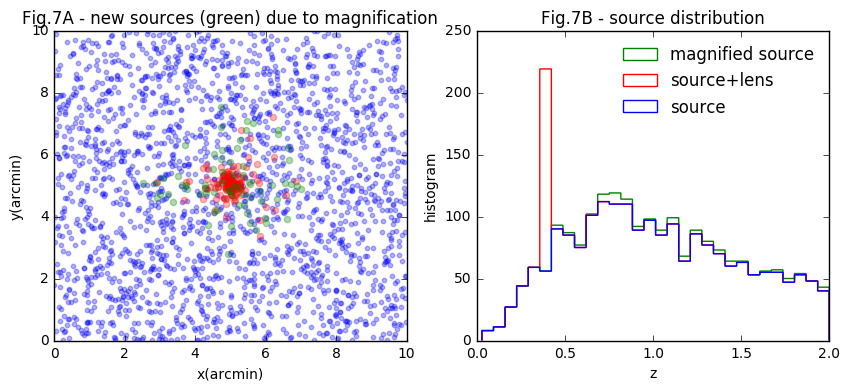

In [25]:
figure(figsize=(10,4))
subplot(121)
scatter(x_source_arr, y_source_arr, s=10, edgecolor='b',c='b',alpha=0.3)#,facecolors='none')
scatter(xlens+side/2, ylens+side/2, s=20, edgecolor='r',c='r',alpha=0.3)#,facecolors='none')
scatter(x_source_new+side/2, y_source_new+side/2, s=20, edgecolor='g',c='g',alpha=0.3)#,facecolors='none')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.7A - new sources (green) due to magnification')
xlim(0,side)
ylim(0,side)
subplot(122)
hist(concatenate([z_source_arr, z_source_new]), bins=30, color='g',histtype='step', label='magnified source')
hist(concatenate([z_source_arr, ones(N_lens)*z_lens]), bins=30, color='r',histtype='step', label='source+lens')
hist(z_source_arr, bins=30, histtype='step',color='b', label='source')
legend(frameon=0,loc=0)
xlabel('z')
ylabel('histogram')
title('Fig.7B - source distribution')
show()

In [26]:
########################################
######## add blending  #################
########################################
rblend = 0.6/60.0 #0.6 arcsec 
#### Bob: maybe a slightly larger value is more reasonable?

xy = concatenate([[xlens+side/2, ylens+side/2],
                        [x_source_arr, y_source_arr],
                        [x_source_new+side/2, y_source_new+side/2]],axis=1).T
#print xy

from scipy.spatial import cKDTree
kdt = cKDTree(xy)
idx_blend = (~isinf(kdt.query(xy,distance_upper_bound=rblend,k=2)[0][:,1]))
x_blend, y_blend = xy[idx_blend].T
z_blend = concatenate([ones(N_lens)*z_lens, z_source_arr, z_source_new])[~idx_blend]
#print len(x_blend)

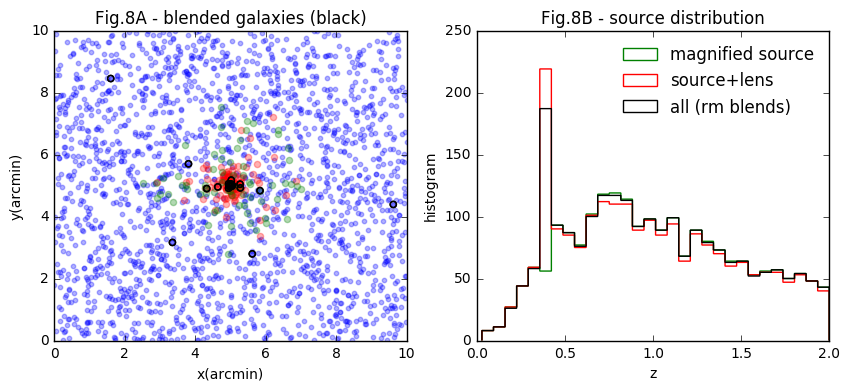

In [27]:
figure(figsize=(10,4))
subplot(121)
scatter(x_source_arr, y_source_arr, s=10, edgecolor='b',c='b',alpha=0.3)
scatter(xlens+side/2, ylens+side/2, s=20, edgecolor='r',c='r',alpha=0.3)
scatter(x_source_new+side/2, y_source_new+side/2, s=20, edgecolor='g',c='g',alpha=0.3)
scatter(x_blend, y_blend,s=20, edgecolor='k',facecolors='none')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.8A - blended galaxies (black)')
dx = 0#0.4
xlim(side*dx,side*(1-dx))
ylim(side*dx,side*(1-dx))
subplot(122)
hist(concatenate([z_source_arr, z_source_new]), bins=30, color='g',histtype='step', label='magnified source')
hist(concatenate([z_source_arr, ones(N_lens)*z_lens]), bins=30, color='r',histtype='step', label='source+lens')
#hist(z_source_arr, bins=30, histtype='step',color='b', label='source')
hist(z_blend, bins=30, histtype='step',color='k', label='all (rm blends)')

legend(frameon=0,loc=0)
xlabel('z')
ylabel('histogram')
title('Fig.8B - source distribution')
show()

In [28]:
###############################
###### add shape noise ########
###############################
kappa_noise_gen = lambda N: normal(0.0, 0.1, size=N) #draw N kappa_noise for sigma_kappa = 0.1 
#shear noise for HSC sigma_g^2=0.365

##x_all, y_all, z_all, kappa_all, noise_all, member, source_mb, blended

x_all = concatenate([x_source_arr, xlens+side/2, x_source_new+side/2])
y_all = concatenate([y_source_arr, ylens+side/2, y_source_new+side/2])
z_all = concatenate([z_source_arr, ones(N_lens)*z_lens, z_source_new])
kappa_all = kappa_proj (M_lens,  z_lens, z_all, x_all, y_all, x_lens=side/2.0, y_lens=side/2.0)[1]
noise_all = kappa_noise_gen(len(x_all))

member, mag, blended = ones(shape=(3, len(x_all)))
member [len(x_source_arr):len(x_source_arr)+len(xlens)] = 0 #### 1 are the sources
mag [-len(x_source_new):] = 0 ### 1 is the ones not magnified
blended [idx_blend] = 0 ## 1 is the ones not blended

r_all = hypot(x_all-side/2.0, y_all-side/2.0)
weight = exp(-0.5*r_all**2)

#kappa_sim = sum((kappa_all + noise_all)*weight*source_mb*blended*member)/ sum(weight *source_mb*blended*member)

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide


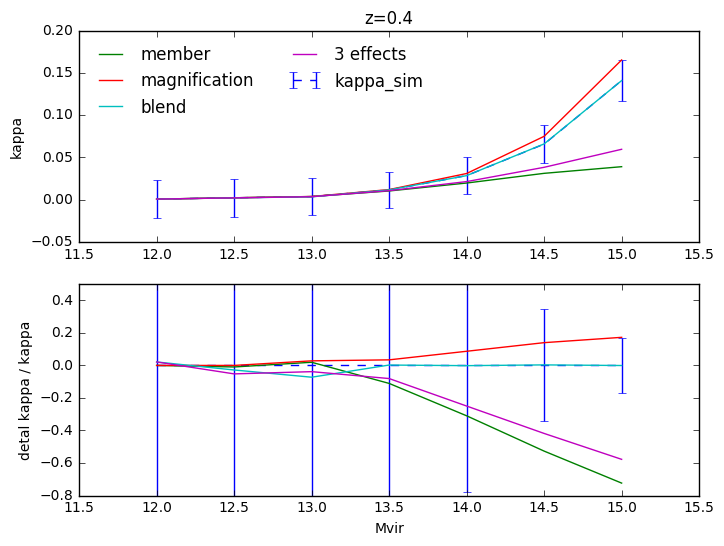

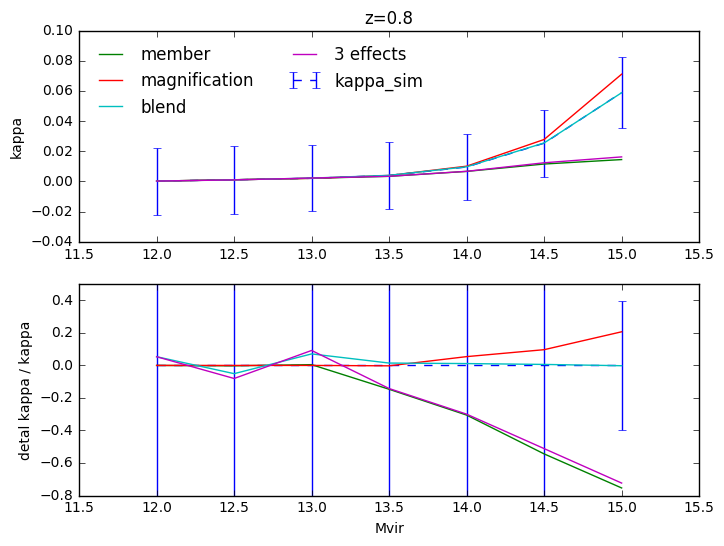

In [29]:
kappa_arr = load('kappa_arr035_theta15.npy')
ksim, knoise, noise, kmem, kmag, kblend, k3eff = [kappa_arr[:,:,:,i] for i in range(7)] ### 7 
logM_bins = arange(12.0,15.5, 0.5)
z_bins = arange(0.2, 2.2, 0.2)
for iii in (1,3):   
    f=figure(figsize=(8,6))
    ax1=f.add_subplot(211)
    ax2=f.add_subplot(212)
    imean_sim=mean(knoise[:,iii],axis=-1)
    ax1.errorbar(logM_bins, imean_sim,std(knoise[:,iii],axis=-1),label='kappa_sim',fmt='--')
    ax2.errorbar(logM_bins,zeros(len(logM_bins)),std(knoise[:,iii],axis=-1)/mean(knoise[:,iii],axis=-1),fmt='--')
    jjj=0
    for imean in [mean(karr[:,iii],axis=-1) for karr in [kmem,kmag,kblend,k3eff] ]:
        ax1.plot(logM_bins, imean, label=['member','magnification','blend','3 effects'][jjj])
        ax2.plot(logM_bins, imean/imean_sim-1)
        jjj+=1

    ax1.set_title('z=%s'%(z_bins[iii]))    
    ax1.legend(frameon=0,ncol=2,loc=0)
    ax2.set_xlabel('Mvir')
    ax1.set_ylabel('kappa')
    ax2.set_ylabel('detal kappa / kappa')
    ax2.set_ylim(-0.8,0.5)
    ax1.set_xlim(11.5, 15.5)
    ax2.set_xlim(11.5, 15.5)
    show()

In [30]:
###################################################
######## put luminosity function to galaxies ######
###################################################

U1band, U2band, U3band, Bband, Gband, Rband, Iband, Zband = range (8)
band_str=('U1 band', 'U2 band', 'U3 band', 'B band', 'G band', 'R band', 'I band', 'Z band')

### variables to set the task ###
ibandOBS = Bband
aMlimOBS = 21
z_arr = np.linspace (.01e-5, 5.0, 200)

alambdaB = np.array([1500.0, 2800.0, 3546.0, 4344.0, 4670.0, 6156.0, 7472.0, 8917.0],dtype=float64)
# 1500.0, 2800.0, 3546.0 are U, 4344.0 is B, 4670.0 is g, 6156.0 is r, 7472.0 is i, 8917, z band
alambdaOBS = alambdaB [ibandOBS]

aMstar0 = np.array([-17.4, -18.16, -18.95, -20.92, -21.0, -21.49, -21.97, -22.22])
phistar0 = np.array([2.71e-2, 2.46e-2, 2.19e-2, 0.82e-2, 0.83e-2, 0.42e-2, 0.34e-2, 0.33e-2])
alpha_arr = np.array([-1.01, -1.06, -1.1, -1.24, -1.26, -1.33, -1.33, -1.33])
aLF = np.array([-2.19, -2.05, -1.8, -1.03, -1.08, -1.25, -0.85, -0.81])
bLF = np.array([-1.76, -1.74, -1.7, -1.27, -1.29, -0.85, -0.66, -0.63])

# find the rest magnitude at the galaxy, from observed magnitude cut
aMlim_fcn = lambda aMlimOBS, z: aMlimOBS - 5.0*log10(DL(z)) - 25.0

aMstar_fcn = lambda z, i: aMstar0[i] + aLF[i]*log(1.0+z) # M* for band i, redshift z
phistar_fcn = lambda z, i: phistar0[i]*(1.0+z)**(bLF[i]) # phi* for band i, redshift z
alphahere_fcn = lambda i: alpha_arr[i] # alpha for band i
alambda_fcn = lambda alambdaOBS, z: alambdaOBS/(1.0+z) # redshift the band to rest

# luminosity function dphi/ dM, aM is the rest Magnitude
arg=lambda aM, z, i: 10.0**(2.0/5.0*(aMstar_fcn(z,i)-aM))#what's aMG?
LF0 = lambda aM, z, i: 2.0/5.0*phistar_fcn(z,i)*(log(10.0))*arg(aM,z,i)**(alphahere_fcn(i)+1.0)*exp(-arg(aM,z,i))

def find_nearest(array,value):
    #find the 2 values in array closes to value, return 1st closes value, 2nd closeset value, 1st index, 2nd index
    idx = (np.abs(array-value)).argsort()
    if value > array[idx[0]]:
        idx2=idx[0]+1
    else:
        idx2=idx[0]-1
    return array[idx[0]],array[idx2],idx[0],idx2

def LF(aMlimOBS, z, i=Iband):
    aM=aMlim_fcn(aMlimOBS,z)
    Restlambda=alambdaB[i]/(1+z)
    
    wL, wR, idxL, idxR = find_nearest(alambdaB,Restlambda)
    if Restlambda < wL and wL == alambdaB[0]:
        phi=LF0(aM, z, 0)
            #print band_str[i],"push to",band_str[0]
    else:
        ratioL = abs(Restlambda-wL)/abs(wL-wR)
        ratioR = abs(Restlambda-wR)/abs(wL-wR)
        phi=ratioR*LF0(aM, z, idxL)+ratioL*LF0(aM, z, idxR)
    return phi
